In [2]:
import torch
from torch import nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
# Hyper Parameter
EPOCH = 1
BATCH_SIZE = 64
TIME_STEP = 28 # 在这里的图片分类中，图片按行作为RNN的每一步，因此一共有28步
INPUT_SIZE = 28 # 每一步中像素的数量为28个
LR = 0.01
DOWNLOAD_MNIST = False

torch.Size([60000, 28, 28])
torch.Size([60000])


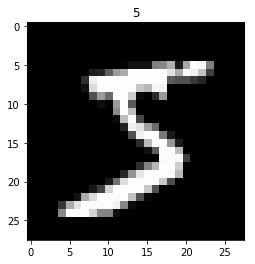

In [13]:
# plot one example# plot  
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [17]:
train_data = dsets.MNIST(
    root='./data/mnist/',
    train=True,
    transform=transforms.ToTensor(),
    download=DOWNLOAD_MNIST
)
train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_data = dsets.MNIST(root='./data/mnist/', train=False)
# 测试数据只需要前2000个就足够了
test_x = test_data.test_data.type(torch.FloatTensor)[:2000] / 255.
test_y = test_data.test_labels[:2000]

In [19]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=64,
            num_layers=1,
            batch_first=True, # 表示输入数据维度为(batch, time_step, input), 如果为False则维度为(time_step, batch, input)
        )
        self.out = nn.Linear(64, 10)
        
    def forward(self, x):
        # r_out中存储每一步step的输出，h_n和h_c存储hidden state，也就是传入下一个RNN单元的状态
        r_out, (h_n, h_c) = self.rnn(x, None)
        # 由于只需要最后一个时刻的输出，而r_out的shape为(batch, time_step, input)，因此只需要传入最后一个时刻输出r_out[:, -1, :]最为self.out的参数计算即可
        out = self.out(r_out[:, -1, :])
        return out
    
rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [33]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = x.view(-1, 28, 28)
        b_y = y
        
        output = rnn(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(step % 50 == 0):
            test_output = rnn(test_x) # test_output是一个size为[2000, 10]的Tensor
            # torch.max()方法是求test_output中最大的值，由于loss_func使用的是CrossEntropy，test_ouput中是0-9每个数字的概率值组成的10个元素的向量
            # squeeze()方法将向量 [[]] 转化为ndarray ()，这样就能在matplotlib中正常绘制
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze() # pred_y是一个shape为(2000, )的ndarray
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            # loss.data就是一个标量（0-d tensor），使用item()将这个数也就是Loss值提取出来
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item(), '| test accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 0.0057 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0450 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0024 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0239 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0407 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0056 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0137 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0734 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0544 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0230 | test accuracy: 0.98
Epoch:  0 | train loss: 0.2052 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0141 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0351 | test accuracy: 0.98
Epoch:  0 | train loss: 0.1592 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0559 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0426 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0345 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0201 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0516 | test accuracy

In [36]:
# print 10 predictions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

[7 2 1 0 4 1 4 9 6 9] prediction number
tensor([ 7,  2,  1,  0,  4,  1,  4,  9,  5,  9]) real number
